#### LIBRARIES USED

In [56]:
import numba
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d

In [149]:
border_value = -2.0
vacancy_value = -1.0
red_value = 0.0
blue_value = 1.0
unhappy_red_value = 2.0
unhappy_blue_value = 3.0
highlight_value = 4.0

In [150]:
def plot_grid(agents):
   
    # creates a discrete colormap
    border = np.array([0,0,0,0.8])                                  # black
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])           # grey
    red = np.array([255.0/255, 0.0/255, 0.0/255])             # red
    blue = np.array([0.0/255, 0.0/255, 255.0/255])          # blue
    unhappy_red = np.array([127.0/255, 0.0/255, 0.0/255])      # dark red
    unhappy_blue = np.array([0.0/255, 0.0/255, 127.0/255])    # dark blue
    highlight = np.array([247.0/255, 236.0/255, 0])           #yellow
    cmap = colors.ListedColormap([border, vacancy, red, blue, unhappy_red, unhappy_blue,highlight])
    # determines the limits of each color:
    # if the agent number x is in the range [border_value,border_value + 1), it's color is black,
    # if x is in the range [vacancy_value, vacancy_value + 1), it's color is grey,
    # and so on...
    bounds = [border_value,vacancy_value,red_value,blue_value,unhappy_red_value,unhappy_blue_value,highlight_value, highlight_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # draws gridlines
    #ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    #ax.set_xticks(np.arange(-0.5, agents.shape[1], 1));
    #ax.set_yticks(np.arange(-0.5, agents.shape[0], 1));

    plt.show()

#### SEGREGATION MODEL

The model describes the evolution of an population in a space with two types of agents: reds and blues. A red agent is happy in it's site depending of it's neighbours; it is the same for the blues.

In [151]:
def create_city(N, red_density, blue_density, city_type):
    vacancy_array = np.array([[-1,-1]])
    # creates a city with borders
    if (city_type == "closed"):
        city = np.full((N+2,N+2), border_value)
        reds = 0.0
        blues = 0.0
        for i in range(1,N+1):
            for j in range(1,N+1):
                rnd = np.random.random()
                if rnd <= red_density:
                    city[i,j] = red_value
                    reds += 1
                elif (red_density < rnd <= red_density + blue_density):
                    city[i,j] = blue_value
                    blues += 1
                else:
                    city[i,j] = vacancy_value
                    vacancy_array = np.append(vacancy_array, [[i,j]], axis=0)
    
    # creates a city without borders, that will be a toroidal grid
    elif (city_type == "open"):
        city = np.full((N,N), vacancy_value)
        reds = 0.0
        blues = 0.0
        for i in range(0,N):
            for j in range(0,N):
                rnd = np.random.random()
                if rnd <= red_density:
                    city[i,j] = red_value
                    reds += 1
                elif (red_density < rnd <= red_density + blue_density):
                    city[i,j] = blue_value
                    blues += 1
                else:
                    vacancy_array = np.append(vacancy_array, [[i,j]], axis=0)
    
    vacancy_array = np.delete(vacancy_array, 0,0)
    
    return city, vacancy_array, reds, blues

In [205]:
def detect_unhappiness(city, city_type, i, j, neighbourhood_range):
    value = city[i,j]
    red_neighbours = 0
    blue_neighbours = 0
    
    if(city_type == "closed"):
        #check red unhappiness
        if(city[i,j] == red_value or city[i,j] == unhappy_red_value):
            red_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # red happiness condition
            if (blue_neighbours > red_neighbours):
                value = unhappy_red_value
            else:
                value = red_value

        #check blue unhappiness
        elif(city[i,j] == blue_value or city[i,j] == unhappy_blue_value):
            blue_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # blue happiness condition
            if (red_neighbours > blue_neighbours):
                value = unhappy_blue_value
            else:
                value = blue_value

                
    elif(city_type == "open"):
        #check red unhappiness
        if(city[i,j] == red_value or city[i,j] == unhappy_red_value):
            red_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # red happiness condition
            if (blue_neighbours > red_neighbours):
                value = unhappy_red_value
            else:
                value = red_value

        #check blue unhappiness
        elif(city[i,j] == blue_value or city[i,j] == unhappy_blue_value):
            blue_neighbours -= 1
            for Di in range(-neighbourhood_range,neighbourhood_range+1):
                for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                    if(city[(i+Di)%N,(j+Dj)%N] == red_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_red_value):
                        red_neighbours += 1
                    elif(city[(i+Di)%N,(j+Dj)%N] == blue_value or city[(i+Di)%N,(j+Dj)%N] == unhappy_blue_value):
                        blue_neighbours += 1

            # blue happiness condition
            if (red_neighbours > blue_neighbours):
                value = unhappy_blue_value
            else:
                value = blue_value

    return value

In [206]:
def detect_city_unhappiness(city, city_type, neighbourhood_range):
    N = city.shape[0]
    unhappy_agents = np.full(((N*N)+1, 2), [-1,-1])
    unhappy_map = np.full((N,N),-1)
    count = 0
    
    if(city_type == "closed"):
        for i in range(1,N+1):
            for j in range(1,N+1):
                value = detect_unhappiness(city, city_type, i, j, neighbourhood_range)
                if(value == unhappy_red_value or value == unhappy_blue_value):
                    count += 1
                    city[i,j] = value
                    unhappy_agents[count] = [i,j]
                    unhappy_map[i,j] = count
                        
    elif(city_type == "open"):
        for i in range(0,N):
            for j in range(0,N):
                value = detect_unhappiness(city, city_type, i, j, neighbourhood_range)
                if(value == unhappy_red_value or value == unhappy_blue_value):
                    count += 1
                    city[i,j] = value
                    unhappy_agents[count] = [i,j]
                    unhappy_map[i,j] = count
    
    unhappy_agents[0] = [count, count]
    
    return city, unhappy_agents, unhappy_map

In [207]:
def simulation_step(city, city_type, unhappy_agents, unhappy_map, vacancy_array, neighbourhood_range):
    if(city_type == "open"):
        n = unhappy_agents[0,0]
        rnd = np.random.randint(1,n+1)
        i = unhappy_agents[rnd,0]
        j = unhappy_agents[rnd,1]

        n2 = vacancy_array.shape[0]
        rnd2 = np.random.randint(0,n2)
        
        # update the vacancy_array
        new_i, new_j = vacancy_array[rnd2]
        vacancy_array[rnd2] = [i,j]
        
        # update the city, unhappy_array and unhappy_map
        a = city[i,j]
        city[new_i,new_j] = city[i,j] - 2
        city[i,j] = vacancy_value
        
        count = unhappy_agents[0,0]
        unhappy_agents[rnd] = unhappy_agents[count]
        unhappy_agents[count] = [-1,-1]
        count -= 1
        unhappy_agents[0] = [count,count]
        unhappy_map[i,j] = -1
        
        # testing purposes
        for _ in range(3):
            city[i,j] = highlight_value
            city[new_i,new_j] = highlight_value
            plot_grid(city)
            time.sleep(0.1)
            display.clear_output(wait=True)
            city[i,j] = vacancy_value
            city[new_i,new_j] = a - 2 
            plot_grid(city)
            time.sleep(0.1)
            display.clear_output(wait=True)
        
        
        # recalculate which agents are unhappy (only the ones affected by the agent that moved)
        for Di in range(-neighbourhood_range,neighbourhood_range+1):
            for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                old_value = city[(i+Di)%N,(j+Dj)%N]
                value = detect_unhappiness(city, city_type, (i+Di)%N, (j+Dj)%N, neighbourhood_range)
                if(value != old_value and value != vacancy_value):
                    city[(i+Di)%N,(j+Dj)%N] = value
                    if(value == unhappy_red_value or value == unhappy_blue_value):
                        count += 1
                        unhappy_agents[count] = [(i+Di)%N,(j+Dj)%N]
                        unhappy_agents[0] = [count,count]
                        unhappy_map[(i+Di)%N,(j+Dj)%N] = count
                    else:
                        pos = unhappy_map[(i+Di)%N,(j+Dj)%N]
                        unhappy_map[(i+Di)%N,(j+Dj)%N] = -1
                        unhappy_agents[pos] = unhappy_agents[count]
                        unhappy_agents[count] = [-1,-1]
                        count -= 1
                        unhappy_agents[0] = [count,count]     
                        
        for Di in range(-neighbourhood_range,neighbourhood_range+1):
            for Dj in range(-neighbourhood_range,neighbourhood_range+1):
                old_value = city[(new_i+Di)%N,(new_j+Dj)%N]
                value = detect_unhappiness(city, city_type, (new_i+Di)%N, (new_j+Dj)%N, neighbourhood_range)
                if(value != old_value and value != vacancy_value):
                    city[(new_i+Di)%N,(new_j+Dj)%N] = value
                    if(value == unhappy_red_value or value == unhappy_blue_value):
                        count += 1
                        unhappy_agents[count] = [(new_i+Di)%N,(new_j+Dj)%N]
                        unhappy_agents[0] = [count,count]
                        unhappy_map[(new_i+Di)%N,(new_j+Dj)%N] = count
                    else:
                        pos = unhappy_map[(new_i+Di)%N,(new_j+Dj)%N]
                        unhappy_map[(new_i+Di)%N,(new_j+Dj)%N] = -1
                        unhappy_agents[pos] = unhappy_agents[count]
                        unhappy_agents[count] = [-1,-1]
                        count -= 1
                        unhappy_agents[0] = [count,count]
                        
        print(unhappy_agents[0,0])
            
    return city, unhappy_agents, unhappy_map, vacancy_array

In [208]:
KERNEL = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]], dtype=np.int8)

SIM_T = 0.75

def evolve(M, boundary='wrap'):
    """
    Args:
        M (numpy.array): the matrix to be evolved
        boundary (str): Either wrap, fill, or symm
    If the similarity ratio of neighbours
    to the entire neighbourhood population
    is lower than the SIM_T,
    then the individual moves to an empty house.
    """
    kws = dict(mode='same', boundary=boundary)
    B_neighs = convolve2d(M == 0, KERNEL, **kws)
    R_neighs = convolve2d(M == 1, KERNEL, **kws)
    Neighs   = convolve2d(M != -1,  KERNEL, **kws)

    B_dissatified = (np.divide(B_neighs, Neighs, where=Neighs!=0.0) < SIM_T) & (M == 0)
    R_dissatified = (np.divide(R_neighs, Neighs, where=Neighs!=0.0) < SIM_T) & (M == 1)
    M[R_dissatified | B_dissatified] = - 1
    vacant = (M == -1).sum()

    N_B_dissatified, N_R_dissatified = B_dissatified.sum(), R_dissatified.sum()
    filling = -np.ones(vacant, dtype=np.int8)
    filling[:N_B_dissatified] = 0
    filling[N_B_dissatified:N_B_dissatified + N_R_dissatified] = 1
    np.random.shuffle(filling)
    M[M==-1] = filling

2


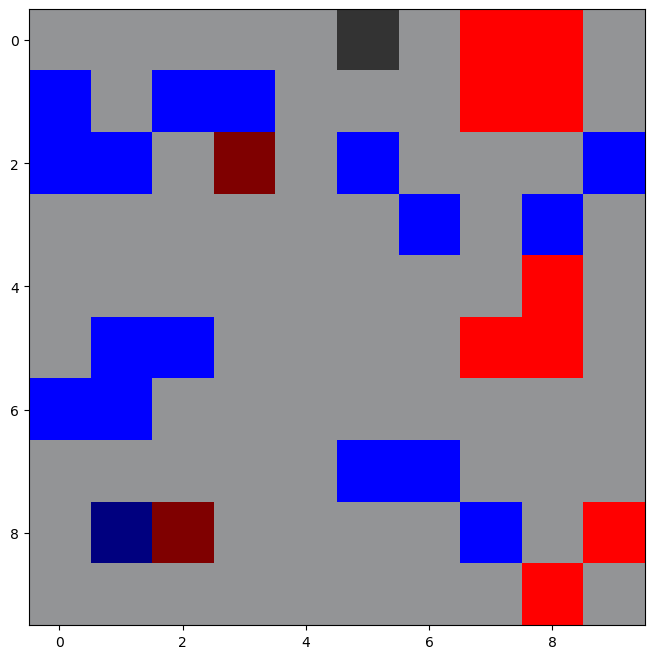

se acabó


KeyboardInterrupt: 

In [209]:
N = 10
red_density = 0.15
blue_density = 0.15
city_type = "open"
neighbourhood_range = 1

city, vacancy_array, reds, blues = create_city(N, red_density, blue_density, city_type) 

plot_grid(city)
time.sleep(2)
display.clear_output(wait=True)

city, unhappy_agents, unhappy_map = detect_city_unhappiness(city, city_type, neighbourhood_range)
plot_grid(city)
print(unhappy_agents)
print(unhappy_map)
time.sleep(2)
display.clear_output(wait=True)

for i in range(50):
    city, unhappy_agents, unhappy_map, vacancy_array = simulation_step(city, city_type, unhappy_agents, unhappy_map, vacancy_array, neighbourhood_range)
    plot_grid(city)
    print("se acabó")
    time.sleep(2)
    display.clear_output(wait=True)


"""
for i in range(150):
    evolve(city)
    if(i%2 == 0):
        plot_grid(city)
        display.clear_output(wait=True)
    
plot_grid(city)
"""

In [63]:
arr = np.array([[i,i] for i in range(1000000)])
arr2 = np.full((1000000,2), [1,1])
#print(arr)

start = time.time()
for i in range(100):
    arr = np.delete(arr,i,0)
    arr = np.append(arr,[[i,i]],axis=0)
end = time.time()
print(end - start)
#print(arr)

start = time.time()
for i in range(100):
    arr = np.insert(arr, i, [[1,1]], axis=0)
end = time.time()
print(end - start)
#print(arr)

start = time.time()
for i in range(10000):
    arr2[i] = [i,i]
end = time.time()
print(end - start)

start = time.time()
for i in range(100):
    arr = np.append(arr, [i,i])
end = time.time()
print(end - start)

0.7376105785369873
0.3869490623474121
0.0059947967529296875
0.3594381809234619


In [134]:
arr = np.array([[0],[1],[2],[3]])
n2 = arr.shape[0]
for _ in range(100):
    a = np.random.randint(0,n2)
    print(a,end=" ")
    print(arr[a],end=" ")

1 [1] 0 [0] 0 [0] 1 [1] 2 [2] 0 [0] 3 [3] 3 [3] 0 [0] 2 [2] 0 [0] 1 [1] 2 [2] 0 [0] 0 [0] 0 [0] 2 [2] 3 [3] 1 [1] 0 [0] 0 [0] 1 [1] 1 [1] 1 [1] 2 [2] 1 [1] 0 [0] 2 [2] 1 [1] 2 [2] 0 [0] 0 [0] 1 [1] 3 [3] 2 [2] 3 [3] 3 [3] 3 [3] 1 [1] 2 [2] 3 [3] 1 [1] 2 [2] 1 [1] 1 [1] 3 [3] 3 [3] 2 [2] 2 [2] 2 [2] 1 [1] 3 [3] 0 [0] 2 [2] 1 [1] 1 [1] 1 [1] 3 [3] 1 [1] 2 [2] 1 [1] 0 [0] 3 [3] 1 [1] 1 [1] 2 [2] 2 [2] 2 [2] 1 [1] 0 [0] 1 [1] 1 [1] 0 [0] 2 [2] 1 [1] 0 [0] 3 [3] 1 [1] 0 [0] 3 [3] 1 [1] 3 [3] 3 [3] 1 [1] 0 [0] 2 [2] 3 [3] 1 [1] 2 [2] 0 [0] 0 [0] 2 [2] 0 [0] 0 [0] 1 [1] 2 [2] 0 [0] 0 [0] 2 [2] 1 [1] 

#### CREATING A GIF

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 ...
 [ 0.  0. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


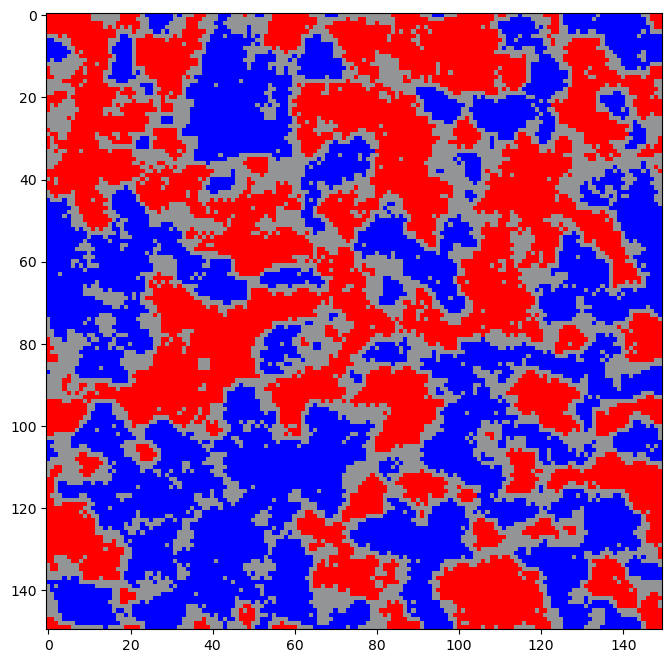

In [226]:
N = 150
red_density = 0.35
blue_density = 0.35

city, city_type, reds, blues = create_city_open(N, red_density, blue_density) 

plot_grid(city)

time.sleep(1)
display.clear_output(wait=True)
#city, unhappy_agents = detect_city_unhappiness(city, city_type)

#plot_grid(city)

for i in range(150):
    evolve(city)
    if(i%2 == 0):
        # REMOVE plt.show() FROM THE plot_grid FUNCTION
        plot_grid(city)
        plt.savefig(str(i) + ".png")
        plt.show()
        
        display.clear_output(wait=True)
    
plot_grid(city)
print(city)

#for _ in range(1000):
#    city, unhappy_agents = simulation_step(city, city_type, unhappy_agents)

#plot_grid(city)

In [217]:
for i in range(0,150,2):
    print(" \'" + str(i) + ".png\',",end='')

 '0.png', '2.png', '4.png', '6.png', '8.png', '10.png', '12.png', '14.png', '16.png', '18.png', '20.png', '22.png', '24.png', '26.png', '28.png', '30.png', '32.png', '34.png', '36.png', '38.png', '40.png', '42.png', '44.png', '46.png', '48.png', '50.png', '52.png', '54.png', '56.png', '58.png', '60.png', '62.png', '64.png', '66.png', '68.png', '70.png', '72.png', '74.png', '76.png', '78.png', '80.png', '82.png', '84.png', '86.png', '88.png', '90.png', '92.png', '94.png', '96.png', '98.png', '100.png', '102.png', '104.png', '106.png', '108.png', '110.png', '112.png', '114.png', '116.png', '118.png', '120.png', '122.png', '124.png', '126.png', '128.png', '130.png', '132.png', '134.png', '136.png', '138.png', '140.png', '142.png', '144.png', '146.png', '148.png',

In [223]:
import os
import imageio.v2 as imageio

In [227]:
with imageio.get_writer('evolucao.gif', mode='I') as writer:
    for filename in ['0.png', '2.png', '4.png', '6.png', '8.png', '10.png', '12.png', '14.png', '16.png', '18.png', '20.png', '22.png', '24.png', '26.png', '28.png', '30.png', '32.png', '34.png', '36.png', '38.png', '40.png', '42.png', '44.png', '46.png', '48.png', '50.png', '52.png', '54.png', '56.png', '58.png', '60.png', '62.png', '64.png', '66.png', '68.png', '70.png', '72.png', '74.png', '76.png', '78.png', '80.png', '82.png', '84.png', '86.png', '88.png', '90.png', '92.png', '94.png', '96.png', '98.png', '100.png', '102.png', '104.png', '106.png', '108.png', '110.png', '112.png', '114.png', '116.png', '118.png', '120.png', '122.png', '124.png', '126.png', '128.png', '130.png', '132.png', '134.png', '136.png', '138.png', '140.png', '142.png', '144.png', '146.png', '148.png']:
        image = imageio.imread(filename)
        writer.append_data(image)